In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tcn.tcn import TCN
from tensorflow import keras

In [2]:
batch_size = 32    # batch
epochs = 100       # epoch
filter_nums = 10   # filter number
kernel_size = 2    # kernel size
predict_day = 10    # how many days you want to predict
window_size = 30+predict_day   # window size
data_PATH = 'data/IT Companies/AAPL.csv'

In [3]:
def get_dataset():
    df = pd.read_csv(data_PATH)
    arr = df['Adj Close'][:-10]
    X = np.zeros(shape=(len(arr) - window_size+1, window_size))
    label = np.zeros(shape=(len(arr) - window_size+1))
    for i in range(len(arr) - window_size+1):
        X[i, :] = np.append(arr[i:i+window_size-1],np.zeros(1))
        if i < len(arr) - window_size:
            label[i] = arr[i+window_size]

#     len_win = len(arr) - window_size
#     for u in range(1,predict_day+1):
#         X[len_win-1+u, :] = np.append(arr[len_win+predict_day:len_win+window_size],np.zeros(predict_day))
#     print(X)
    train_X = X[:-1, :]
    train_label = label[:-1]
    test_X = X[-1:, :]
    test_label = label[-1:]
    return train_X, train_label, test_X, test_label
get_dataset()

(array([[1.43028000e-01, 1.50463000e-01, 1.53088000e-01, ...,
         2.41878000e-01, 2.41878000e-01, 0.00000000e+00],
        [1.50463000e-01, 1.53088000e-01, 1.56587000e-01, ...,
         2.41878000e-01, 2.44940000e-01, 0.00000000e+00],
        [1.53088000e-01, 1.56587000e-01, 1.56587000e-01, ...,
         2.44940000e-01, 2.36192000e-01, 0.00000000e+00],
        ...,
        [1.45422119e+02, 1.48926865e+02, 1.48257874e+02, ...,
         1.53649994e+02, 1.54300003e+02, 0.00000000e+00],
        [1.48926865e+02, 1.48257874e+02, 1.46170990e+02, ...,
         1.54300003e+02, 1.56690002e+02, 0.00000000e+00],
        [1.48257874e+02, 1.46170990e+02, 1.42236893e+02, ...,
         1.56690002e+02, 1.55110001e+02, 0.00000000e+00]]),
 array([  0.236192,   0.227444,   0.236629, ..., 155.110001, 154.070007,
        148.970001]),
 array([[146.17099 , 142.236893, 145.931351, 145.18248 , 146.580383,
         148.337753, 148.76712 , 146.55043 , 144.763107, 145.422119,
         145.641785, 145.302307,

In [4]:
train_X, train_label, test_X, test_label = get_dataset()

model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size, 1)),
    TCN(nb_filters=filter_nums,                  
        kernel_size=kernel_size,                 
        dilations=[1, 2, 4, 8]),                 
    keras.layers.Dense(units=1, activation='relu')
])

model.summary()
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.fit(train_X, train_label, validation_split=0.2, epochs=epochs)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 10)                1520      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
218/218 [==============================] - 1s 3ms/step - loss: 0.3978 - mae: 0.3978 - val_loss: 2.1917 - val_mae: 2.1917
Epoch 2/100
218/218 [==============================] - 1s 2ms/step - loss: 0.1172 - mae: 0.1172 - val_loss: 1.3052 - val_mae: 1.3052
Epoch 3/100
218/218 [==============================] - 1s 2ms/step - loss: 0.1005 - mae: 0.1005 - val_loss: 1.6608 - val_mae: 1.6608
Epoch 4/100
218/218 [==============================] - 1s 2ms/step - loss: 0.1053 - mae: 0.1053 - val_loss: 1.8820 - 

In [5]:
test_X[0]
train_X, train_label, test_X, test_label = get_dataset()

In [6]:
p_arr = []
for i in range(predict_day):
    model.evaluate(test_X, test_label)
    prediction = model.predict(test_X).reshape(-1)
    test_X[0][-1] = prediction
    test_X[0] = np.append(test_X[0][1:],np.zeros(1))
    p_arr.append(prediction[0])
#     print(test_X[0])

1/1 [==============================] - 0s 11ms/step - loss: 158.5470 - mae: 158.5470


In [7]:
print(test_label)
print(p_arr)

[0.]
[154.34438, 154.71713, 154.91151, 155.4529, 155.76411, 156.18428, 156.66222, 157.35329, 158.14165, 158.54695]


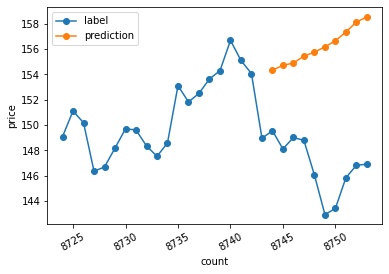

In [8]:
df = pd.read_csv(data_PATH)
p_arr_plot = np.empty_like(df['Adj Close'][-30:])
p_arr_plot[:] = np.nan
p_arr_plot[-predict_day:] = p_arr

pdf = pd.DataFrame({'label': df['Adj Close'][-30:], 'prediction':p_arr_plot})
pdf.plot(rot=30, marker = 'o')
plt.ylabel('price')
plt.xlabel('count')
plt.show()